# Netflix Stock Prediction using LSTM

This project uses the LSTM to predict the closing price of Netflix stock based on the performance of the previous 60 days

### Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import datetime as dt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

### Loading the dataset

In [3]:
stock = pd.read_csv('NFLX.csv', index_col = "Date")
stock

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2017-09-11,178.100006,182.470001,178.029999,181.740005,181.740005,5979400
2017-09-12,182.550003,185.330002,180.639999,185.149994,185.149994,6689600
2017-09-13,184.070007,184.500000,182.550003,183.639999,183.639999,4320300
2017-09-14,183.250000,185.289993,182.070007,182.630005,182.630005,4510700
2017-09-15,182.729996,184.929993,181.429993,182.350006,182.350006,5591700
...,...,...,...,...,...,...
2022-09-01,220.720001,230.369995,219.470001,230.039993,230.039993,7292900
2022-09-02,231.029999,233.880005,225.039993,226.110001,226.110001,8155600
2022-09-06,225.589996,226.850006,214.690002,218.389999,218.389999,7469000


### Plotting the High and Low values over the five year period

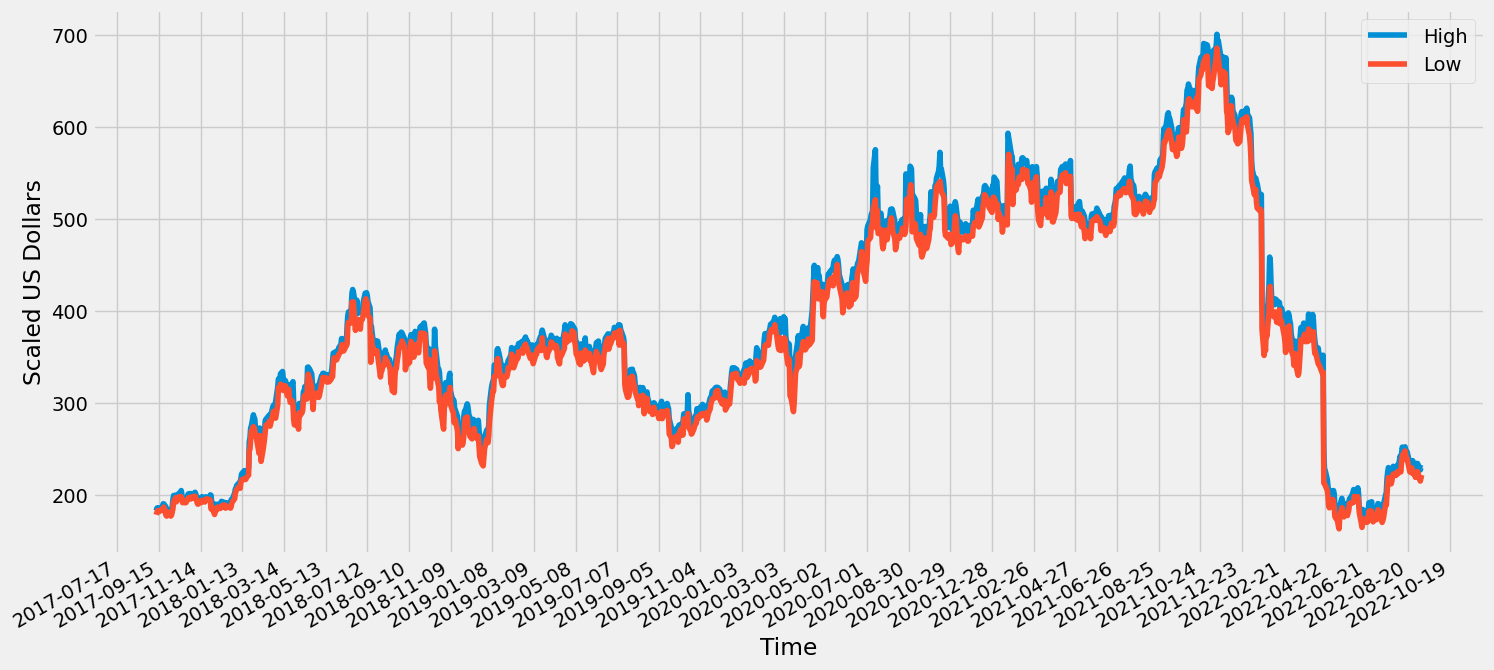

In [4]:
plt.figure(figsize = (16,8))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval = 60))
x_dates = [dt.datetime.strptime(d, '%Y-%m-%d').date() for d in stock.index.values]
plt.plot(x_dates, stock["High"], label = "High")
plt.plot(x_dates, stock["Low"], label = "Low")
plt.xlabel("Time")
plt.ylabel("Scaled US Dollars")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()

### Processing the data

In [8]:
#Getting the Close values
data = stock[['Close']]
dataset = data.values

#Scaling the data
sc = MinMaxScaler(feature_range = (0,1))
scaled = sc.fit_transform(dataset)

### Creating training sets

In [9]:
#Creating 80-20 test split
train_split = .8
split_index = int(np.ceil(len(dataset)*train_split))

#Creating X and y training sets
train = scaled[0:split_index, :]
x_train, y_train = [], []
for i in range(60, len(train)):
    x_train.append(train[i-60:i, 0])
    y_train.append(train[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

### Building and compiling the model

In [27]:
#Creating the model
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape = (x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))


#Compiling the model using MSE as the loss function
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

### Fitting the model on the training data and evaluating on the test data

In [29]:
#Train the model
model.fit(x_train, y_train, batch_size = 32, epochs = 50)

#Make test sets
test = scaled[split_index - 60: , :]
x_test = []
y_test = dataset[split_index:, :]

for i in range(60, len(test)):
    x_test.append(test[i-60:i, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

predictions = model.predict(x_test)
predictions = sc.inverse_transform(predictions)

#Calculate RMSE
rmse = np.sqrt(np.mean(predictions - y_test)**2)
print('RMSE: ' + str(rmse))

Epoch 1/50


30/30 [==============================] - 4s 125ms/step - loss: 0.0014
Epoch 2/50
30/30 [==============================] - 3s 108ms/step - loss: 0.0014
Epoch 3/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0014
Epoch 4/50
30/30 [==============================] - 2s 63ms/step - loss: 0.0013
Epoch 5/50
30/30 [==============================] - 2s 73ms/step - loss: 0.0013
Epoch 6/50
30/30 [==============================] - 2s 71ms/step - loss: 0.0013
Epoch 7/50
30/30 [==============================] - 2s 72ms/step - loss: 0.0013
Epoch 8/50
30/30 [==============================] - 2s 76ms/step - loss: 0.0012
Epoch 9/50
30/30 [==============================] - 2s 73ms/step - loss: 0.0011
Epoch 10/50
30/30 [==============================] - 2s 72ms/step - loss: 0.0012
Epoch 11/50
30/30 [==============================] - 2s 68ms/step - loss: 0.0012
Epoch 12/50
30/30 [==============================] - 2s 78ms/step - loss: 0.0013
Epoch 13/50
30/30 [===========================

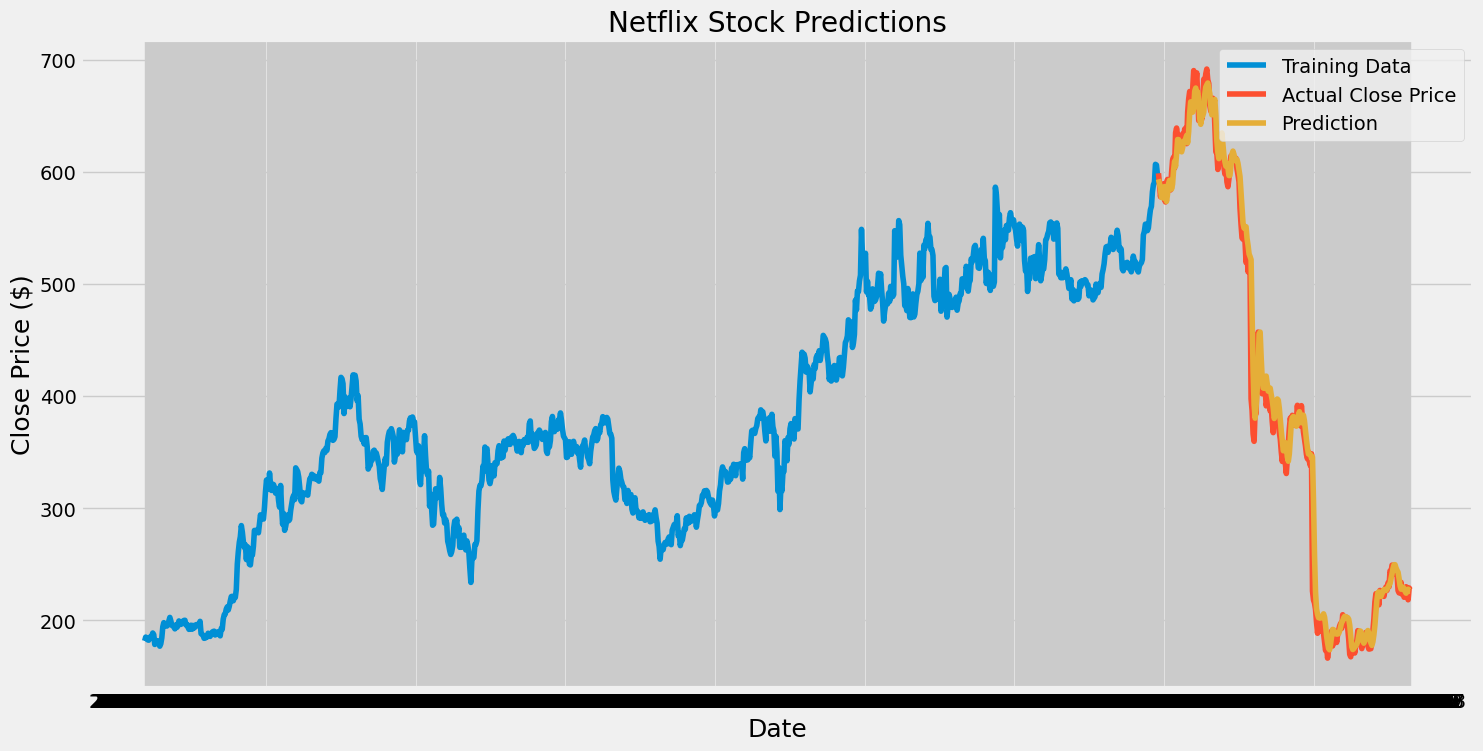

In [30]:
#Plot
training = data[:split_index]
actual = data[split_index:]
actual['Predictions'] = predictions
plt.figure(figsize = (16,8))
plt.title("Netflix Stock Predictions")
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Close Price ($)', fontsize = 18)
plt.plot(training['Close'])
plt.plot(actual[['Close', 'Predictions']])
plt.legend(['Training Data', 'Actual Close Price', 'Prediction'], loc = 'upper right')
plt.show()

### Table showing the actual prices versus the predicted prices

In [31]:
actual['Absolute differences'] = np.abs(actual['Close'] - actual['Predictions'])
actual

,Close,Predictions,Absolute differences
Date,,,
2021-09-10,598.719971,593.404358,5.315613
2021-09-13,589.289978,589.883423,0.593445
2021-09-14,577.760010,584.998413,7.238403
2021-09-15,582.869995,577.356628,5.513367
2021-09-16,586.500000,576.791260,9.708740
...,...,...,...
2022-09-01,230.039993,224.294006,5.745987
2022-09-02,226.110001,226.045929,0.064072
2022-09-06,218.389999,227.841965,9.451966


Our LSTM model seems to predict the stock prices decently. However, there are many external factors that affect stock price, and this model alone should not solely be used to forecast future closing prices